In [22]:
# Standardopsætning (kør denne først)
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)
np.random.seed(42) # YEAH 42

# Dansk labels i figurer
plt.rcParams['figure.figsize'] = (9, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

# PCG og mekaniske hændelser: Filtering og feature-timing

**Udtræk og visualisering af SCG/PCG-data**

I denne lektion arbejder vi med:
- **PCG (Phonocardiography)**: Hjertelyde optaget via stetoskop

**Fokus:**
- Indlæsning og inspektion af PCG-data
- Forståelse af hvad signaler består 
- Visualisering med subplots for sammenligning
- Forberedelse til filtrering og feature-ekstraktion


# Mål for dagens forelæsning

- Forstå SCG/PCG signaler og deres frekvensindhold
- Finde S1 og S2 lyde
- Synkronisér events/features mellem ECG og SCG (R→S1,S2 timing)
- Kvantificér variabilitet med histogrammer


## Dagens struktur – kort overblik

1. **Hvad er PCG?** – Lyd fra hjertet, frekvensindhold, udfordringer
2. **Filtrering** – Valg af cut-off via spektrum, zero-phase (Butterworth)
3. **Envelope** – Sådan fremhæves hjertelydene
4. **Peak-detektion** – Find S1 og S2 i envelopen
5. **Klassifikation** – S1 vs. S2 via tidsintervaller
6. **Validering** – Histogram over intervaller, variabilitet



# Brug histogram til at finde information
- Afslør baggrundsstøj vs. signal ved fordelingens form
- Se efter brede/skæve fordelinger (støj) vs. skarpe toppe (signal)
- Eksempel nedenfor med tilfældigt datasæt (støj): waveform + histogram

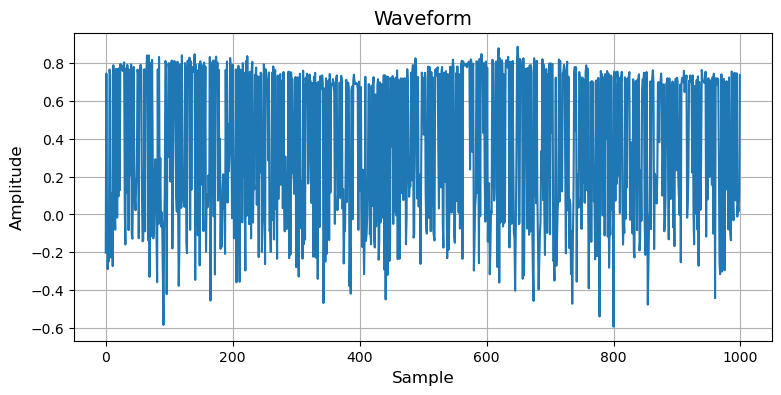

In [23]:
d = np.loadtxt("files/random_dist.csv")
t = np.arange(len(d))
plt.plot(t,d)
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()


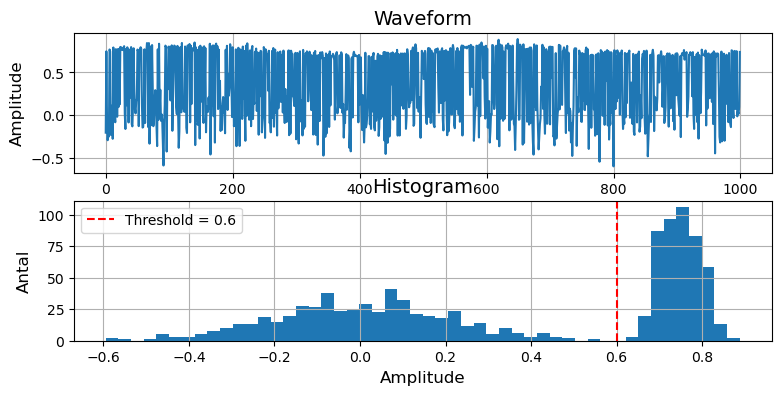

In [24]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t,d)
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Waveform")
axs[1].hist(d,   bins=50)
axs[1].axvline(x=0.6, color='r', linestyle='--', label=f'Threshold = {0.6}')
axs[1].set_xlabel("Amplitude")
axs[1].set_ylabel("Antal")
axs[1].set_title("Histogram")
axs[1].legend()
plt.show()


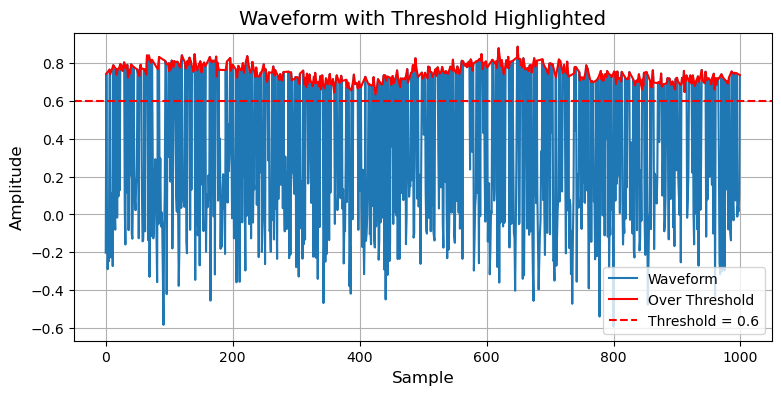

In [25]:
threshold = 0.6
# tid og værdi for samples over / under threshold
t_over = t[d > threshold]
d_over = d[d > threshold]
plt.plot(t,d, label="Waveform")
plt.plot(t_over, d_over, 'r', label="Over Threshold")
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Waveform with Threshold Highlighted")
plt.legend()
plt.show()  

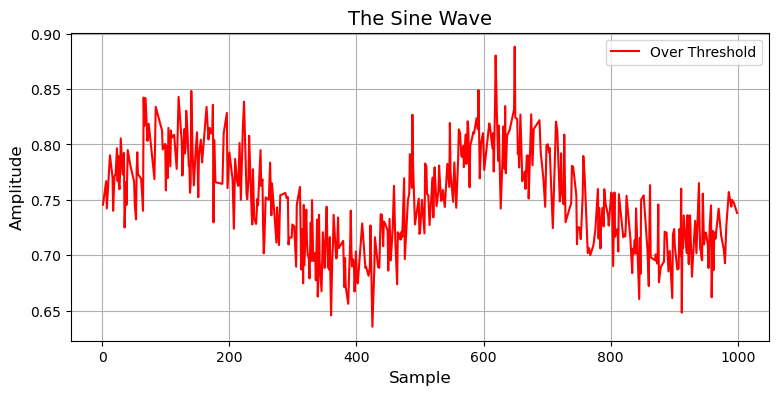

In [26]:
plt.plot(t_over, d_over, 'r', label="Over Threshold")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("The Sine Wave")
plt.legend()
plt.show()  


# Finde S1 og S2 lyde

- Filtrér signalet zero‑phase (Butterworth + filtfilt) for tydelige events.
- Beregn envelopen af det filtrerede signal.
- Peak Detection
- Beregn tidsafstande (intervaller) mellem peaks. 
- Klassificér S₁ og S₂ ud fra korte/lange intervaller.
- Validér med histogram over intervaller. 
## Data Workflow

```mermaid
flowchart LR
    A[**Load Data**] --> B[**Inspect**]
    B --> C[Clean]
    C --> D[Visualize]
    D --> E[Extract Features]
    E --> F[Store]
```

## For at finde S1 og S2 skal I kunne:

**Signalforbehandling (Data Preparation)**
- Inspicere rå data: skalering, outliers, artefakter
- Vælge passende filtre baseret på frekvensindhold (spectral analyse)
- Anvende zero-phase filtrering uden tidsforskydning

**Feature‑detektion (Feature Finding)**
- Beregne envelope til at fremhæve events
- Finde lokale maxima (peaks) med robuste parametre
- Kvantificere afstande mellem features

**Feature‑klassifikation (Classification)**
- Skelne mellem feature-typer via tidsintervaller eller anden kontekst
- Anvende fysiologiske regler til at mærke events
- Validere klassifikation mod vidtkendte mønstre

**Analyse & Kommunikation**
- Visualisere både signal og features
- Bruge histogrammer til at vurdere variabilitet og outliers
- Dokumentere valgte parametre og deres begrundelse

**Generalisering**: Disse trin gælder for alle signalanalyse-opgaver — EMG, EEG, accelerometer, osv.


### Exercise: Load data fra fil
**Scenarie:**

Du er ansat som dataanalytiker på et hospital og har netop modtaget en fil med målinger fra et forsøg, hvor både EKG og PCG er optaget samtidig. Din opgave er at indlæse og visualisere signalerne, så du kan vurdere kvaliteten og få et første overblik over data. Dette er et vigtigt første skridt, før du kan gå videre med mere avanceret analyse.

**Du ved:**
- Hvordan man loader data fra en fil
- Hvordan man visualiserer et signal, og får det til at se "pænt" ud

**Du skal:**
- Load `timestamp`, `ecg`, `pcg` fra `files/ECGPCG.csv` med `np.loadtxt()`
- Skipper første linje (column headers) med `skiprows=1`
- Plot begge signaler for at inspicere dem

**Skriv dit program i:** `files/load_and_plot_ecgpcg.py`

### Answer

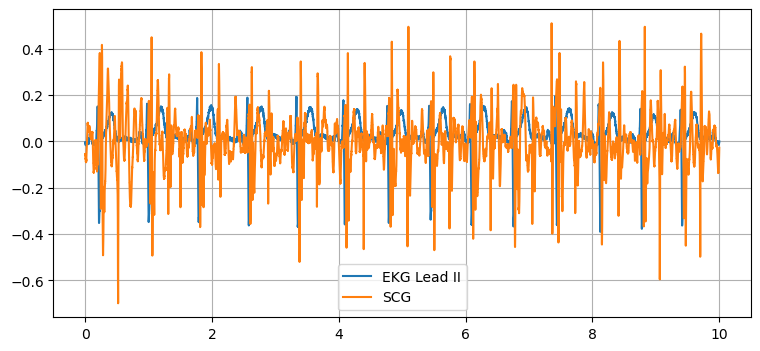

In [27]:
import numpy as np
import matplotlib.pyplot as plt
filename = "files/ECGPCG.csv"
timestamp, ecg, pcg = np.loadtxt(filename,delimiter=",", skiprows=1, unpack=True)

plt.plot(timestamp, ecg, label="EKG Lead II")
plt.plot(timestamp, pcg, label="SCG")
plt.legend()
plt.show()


## Subplots giver overblik

* Adskiller signaler og reducerer visuel støj
* Muliggør direkte sammenligning via fælles tidsakse
* Tillader korrekt skalering af hvert signal
* Forbedrer læsbarhed og fortolkning


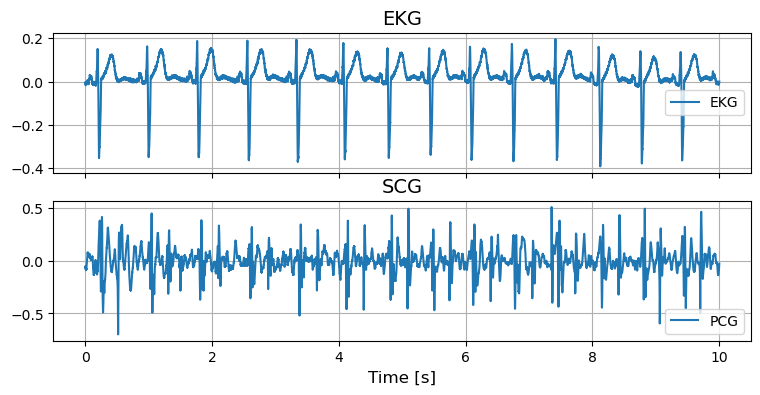

In [28]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(timestamp, ecg, label="EKG")
axs[0].legend()
axs[0].set_title("EKG")
axs[1].plot(timestamp, pcg, label="PCG")
axs[1].legend()
axs[1].set_xlabel("Time [s]")
axs[1].set_title("SCG")
plt.show()

## Clean Data

```mermaid
flowchart LR
    A[Load Data] --> B[Inspect]
    B --> C[**Clean**]
    C --> D[Visualize]
    D --> E[Extract Features]
    E --> F[Store]
```

# Exercise: moving average (mov)?
**Scenarie:**

Du arbejder som ingeniør på et hospital, hvor du skal hjælpe med at analysere hjertelyde fra patienter. Et af problemerne er, at optagelserne ofte indeholder både hjertelyde og baggrundsstøj fra omgivelserne (fx snak, apparater, bevægelser). For at kunne analysere hjertelydene korrekt, skal støjen fjernes fra signalet, så S1 og S2 bliver tydeligere, uden at vigtige detaljer forsvinder.

**Du ved:**

* Hvordan man filtrerer med et moving average filter


**Du skal:**
1. Hver især (altså ikke flere på samme PC); I programmet `files/adjust_mov_practice.py` ændre `window` til en størrelse så DU mener at signalet er godt.
2. Snak med hinanden:
    - Argumenter for dit `window` valg, og hvorfor det er bedre! (I skal ikke ændre jeres valg)
    - Hvad ved I ved omkring et PCG signal.
    - Fjerner moving average højfrekvens eller lavfrekvens støj?
    - Giver et moving average filter mening?
    - Hvad er støj?

## Svar
- Data er gemt med 8000Hz.
- Men hvorfor siger jeg det?

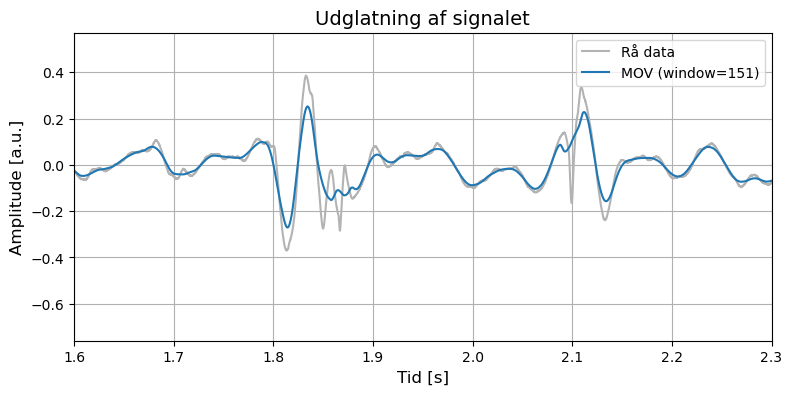

In [29]:
# %load files/adjust_mov_practice.py
# Moving average (for reference)
from scipy.ndimage import uniform_filter1d
from scipy.signal import butter, filtfilt, medfilt
import numpy as np
import matplotlib.pyplot as plt

# Juster window 
window = 151
filename = "files/ECGPCG.csv" # Hvis du får en FileNotFoundError, prøv at fjern "files/" fra string.

"""
Lad være med at ændre noget herunder. 
OGSÅ selvom i får en error.
(det gør i bl.a. hvis window er et lige tal)
"""
fs = 8000 # sample rate Hz

# HEY LOOK; Du kan også bare loade specifikke columns! (der er 5 columns i filen)
timestamp, ecg, pcg = np.loadtxt(filename,delimiter=",", skiprows=1, unpack=True)

x = pcg # 4 sekunder af SCG signalet
t = timestamp 

# moving average filter (du kan lave et MOV på MANGE måder)
x_ma = uniform_filter1d(x,window)

plt.figure()
plt.plot(t, x, color='0.7', label='Rå data')
plt.plot(t, x_ma, label=f'MOV ({window=})')
plt.title('Udglatning af signalet')
plt.xlabel('Tid [s]')
plt.ylabel('Amplitude [a.u.]')
plt.xlim([1.6, 2.3])
plt.legend()
plt.show()


- Der er ikke noget godt svar for en window size.
  - Dette er fordi S1 og S2 signalerne bl.a. indeholder **lavfrekens** støj. 
  - MOV fjerner de højere frekvenser

# Hvad er et PCG?
```mermaid
flowchart LR
    A[Load Data] --> B[**Inspect**]
    B --> C[Clean]
    C --> D[Visualize]
    D --> E[Extract Features]
    E --> F[Store]
```

## Know your data!
- PCG: Phonocardiography 
- Det er et stetoskop.
- $50Hz < \textbf{det menneskelige auditive spektrum} < 20 000 Hz$



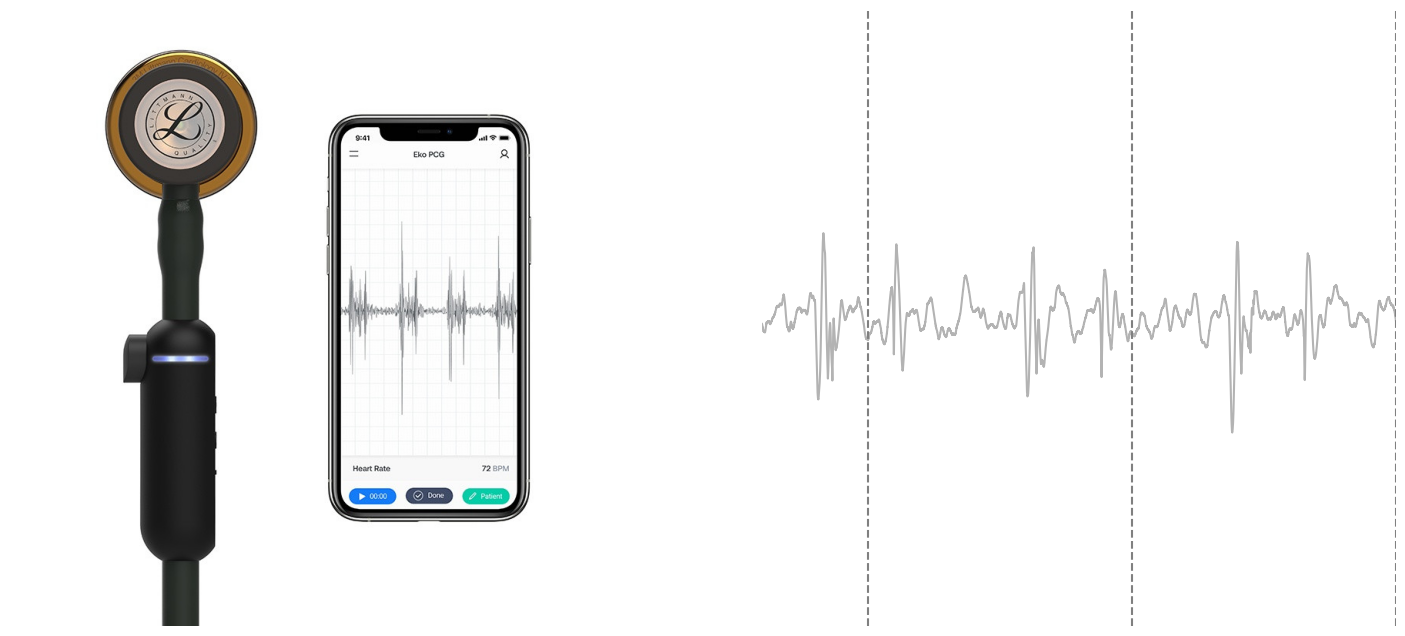

In [30]:
fig, axs =plt.subplots(1,2, figsize=(18,8))
axs[0].imshow(plt.imread("files/stetoskop.jpg"))
axs[0].axis('off')               # hides axes and ticks

axs[1].plot(t, x, color='0.7', label='Rå data')
axs[1].set_xlim([1.6, 4])
axs[1].set_ylim(np.array([-1.3,1.5])-0.1)
# vertical line at 2.1 s
for i in range(5):
    axs[1].axvline(x=i, color='gray', linestyle='--', label='Hjerte lyd')
axs[1].axis('off')               # hides axes and ticks
plt.show()


# PCG er Lyd
For at spille en lydfil gennem python (Ikke Jupyter!), kan man bruge pakken `sounddevice`,
herefter kan man fx køre programmet `files/play_sound.py`

>```python 
>import sounddevice as sd
>from scipy.signal import resample
>import numpy as np
>filename = "files/b001.csv"
>data = np.loadtxt(filename,delimiter=",", skiprows=1, unpack=True, usecols=[3])
>fs = 5000 # orginal sampling frekvens
># sounddevice kan ikke finde ud af 5000Hz, så vi konverterer det om (resampler) til 44100Hz
>fs_new = 44100 # Normal 
>num_samples = int(len(data) * fs_new / fs)
>data_resampled = resample(data, num_samples)
>sd.play(data_resampled, fs_new)
>sd.wait()           # Wait until playback finishes
>```

### I jupyter, kan jeg bare skrive:

In [31]:
from IPython.display import Audio
Audio(pcg, rate=fs,normalize=True)

# Clean + Vizualize
### Valg af cut-off via spektral information (Spektral / Frekvens Spektret)



```mermaid
flowchart LR
    A[Load Data] --> B[Inspect]
    B --> C[Clean]
    C --> D[**Visualize**]
    D --> E[Extract Features]
    E --> F[Store]
```

**Sådan finder man LUB DUB**
- Sæt lavpas hvor du mener hovedindholdet af hjertelydene er for at fjerne lav frekvens støj, men bevare events.
- For et PCG er signalet imellem 50 og 300Hz


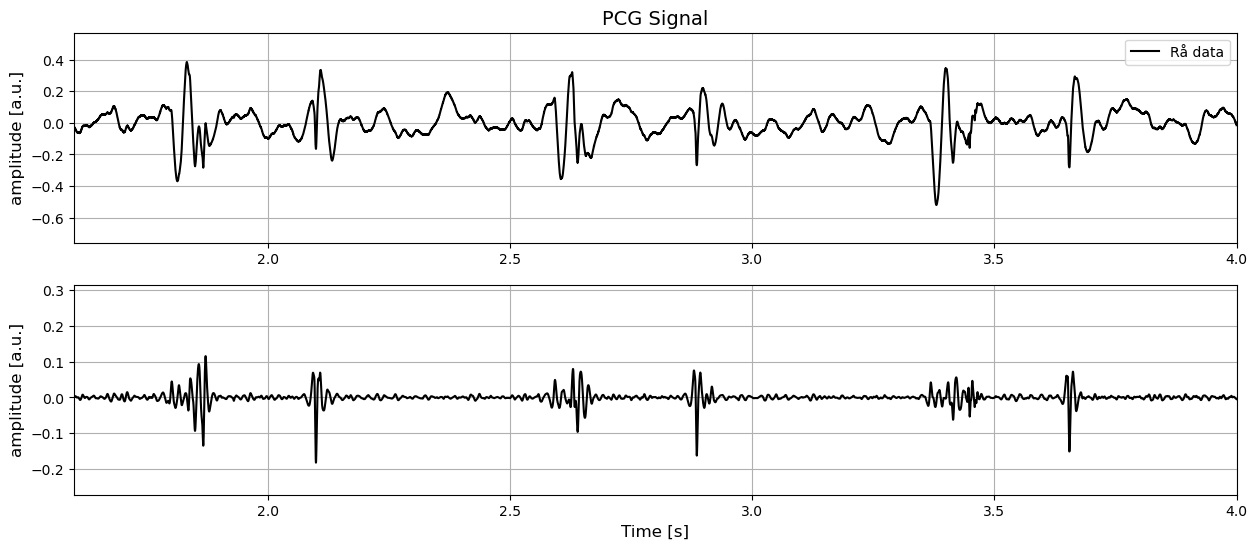

In [58]:
# Welch-PSD for at motivere cut-off

from scipy.signal import butter, freqz, filtfilt, welch
fs=8000
fc = [50,300]

# Butterworth zero-phase
b, a = butter(4, fc, fs=fs, btype='bandpass') # type: ignore
lubdub = filtfilt(b, a, x)
t_lubdub = np.linspace(0,len(lubdub)/fs, len(lubdub))
# Visualize
fig,axs = plt.subplots(2,1, figsize=(15,6)) 
axs[0].plot(t, x, label='Rå data', color='black')
axs[0].set_ylabel('amplitude [a.u.]')
axs[0].legend()
axs[1].plot(t_lubdub,lubdub, color='black')
axs[1].set_ylabel('amplitude [a.u.]')
axs[0].set_title('PCG Signal')
axs[1].set_xlabel('Time [s]')

axs[1].set_xlim([1.6, 4])
axs[0].set_xlim([1.6, 4])

plt.show()

In [59]:

from IPython.display import Audio
Audio(lubdub, rate=fs,normalize=True)

# Feature Extraction
Hvordan finder jeg ud af hvordan jeg skal få den information jeg har interesse i?

### Udgangspunkt: S₁ og S₂
```mermaid
flowchart LR
    A[Load Data] --> B[Inspect]
    B --> C[Clean]
    C --> D[Visualize]
    D --> E[**Extract Features**]
    E --> F[Store]
```

## Hvor kommer S₁ og S₂ fra?

<div style="display: flex; align-items: flex-start; gap: 30px;">
    <div style="flex: 1;">
        <h3>S₁ – <em>første hjertelyd</em></h3>
        <ul>
            <li>Opstår når <strong>mitralklappen og trikuspidalklappen lukker</strong></li>
            <li>Marker starten på <strong>systolen</strong> (hjertets pumpefase)</li>
            <li>Ofte beskrevet som <strong>"lub"</strong></li>
            <li>Har typisk <strong>lavere frekvens</strong> og lidt længere varighed</li>
        </ul>
        <h3>S₂ – <em>anden hjertelyd</em></h3>
        <ul>
            <li>Opstår når <strong>aortaklappen og pulmonalklappen lukker</strong></li>
            <li>Marker slutningen af systolen / starten på <strong>diastolen</strong></li>
            <li>Ofte beskrevet som <strong>"dub"</strong></li>
            <li>Typisk <strong>kortere og lidt højere frekvens</strong> end S₁</li>
        </ul>
    </div>
    <div style="flex: 0 0 1000px;">
        <img src="files/hjete.png" alt="hjertet" style="width: 100%; max-width: 400px;">
    </div>
</div>

## Overblik: idéen bag S₁ / S₂-detektion


![Image](files/S1S2_1.jpg)
![Image](files/S1S2_2.jpg)

## Fysiologiske observationer for S₁ og S₂

**I én hjertesyklus gælder typisk:**
* **S₁ → S₂** : *kort interval* (systole)
* **S₂ → næste S₁** : *længere interval* (diastole)

**PCG indenhold:**
* S₁ og S₂ (de dominerende lyde)
* Eventuelle ekstra hjertelyde (S₃, S₄)
* Støj fra vejrtrækning og omgivelser

**Ideen**
1. Beregn **Envelopen** af PCG-signalet
2. Find **lokale maxima (peaks)** i envelopen
3. Brug **tidsafstande mellem peaks** til at skelne S₁ og S₂



# The Envelope


## Hvad er en Envelop?
En **envelope** er et “tæppe” lagt over et signal, som fremhæver dets overordnede form og hjælper med at tydeliggøre vigtige elementer.

Eksempel: **S₁** og **S₂** hjertelyde et et PCG.


* Følger signalets energi / amplitude
* Gør det meget lettere at se og detektere S₁ og S₂ som peaks
* Ofte bruges som første trin i automatisk hjertelydsanalyse


## Hvorfor bruge en Envelop?

* Fremhæver signalets amplitudeændringer
* Gør mønstre lettere at se/identificerer
* Hjælper med analyse af komplekse signaler


## Envelope Extraction

Sådan kan man lave en Envelope (env) via maximum værdier
>```zsh
>FUNKTION envelope(signal, window): 
>   BEREGN mean_value = gennemsnit af signal
>   s0 = signal - mean_value
>   r = rectificer s0 (absolut værdi af s0)
>   OPRET mov_max som tomt array med samme længde som r
>   FOR HVER indeks i FRA 0 TIL længde af r:
>     start = maksimum af (i - half_w, 0)
>     end = minimum af (i + half_w + 1, længde af r)
>     mov_max[i] = maksimum værdi i r[start:end]
>  env = mov_max + mean_value
>  RETURNER env
```


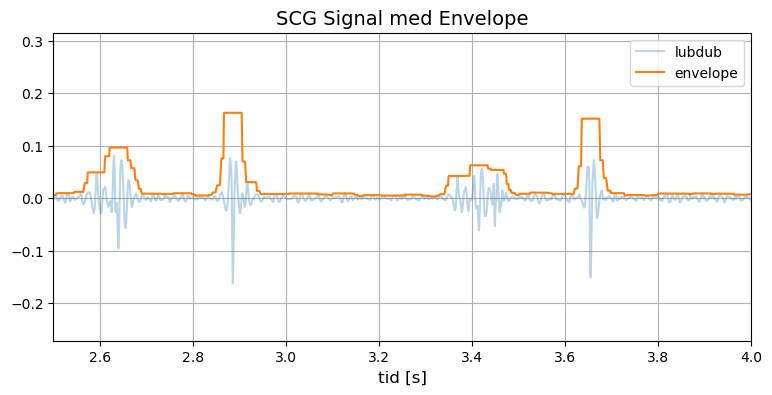

In [60]:
import numpy as np

def envelope(x, window=50):
    """
    Beregn en envelope for et signal x.
    """
    # 1. Fjern gennemsnittet
    mean_x = np.mean(x)
    s0 = x - mean_x

    # 2. Rectify (absolut værdi)
    r = np.abs(s0)

    # 3. Moving Maximum
    mov_max = np.zeros_like(r)
    half_w = window // 2
    for i in range(len(r)):
        start = max(i - half_w, 0)
        end = min(i + half_w + 1, len(r))
        mov_max[i] = np.max(r[start:end])

    # 4. Tilføj gennemsnittet tilbage
    env = mov_max + mean_x
    return env

e = envelope(lubdub,window=301)
plt.plot(t_lubdub,lubdub, label="lubdub", alpha=0.3)
plt.plot(t_lubdub,e, label="envelope")
plt.legend()
plt.xlabel("tid [s]")
plt.xlim([2.5, 4])
plt.title("SCG Signal med Envelope")
plt.show()

## Find peaks i envelopen

> ```python
> # Trin 1: Identificér regler for hvad der er et peak
> # Eksempler på regler:
> #   - Minimum peak-højde (fx std(e))
> #   - Minimum afstand mellem peaks (fx 0.15s)
> #   - (Evt. andre: prominence, width, threshold, ...)
> # Trin 2: Brug find_peaks med dine valgte regler
> from scipy.signal import find_peaks
> peaks, _ = find_peaks(e, height=..., distance=...)
>     
> ```

- Eksempler på regler: `height=std(e)`, `distance=int(0.15*fs)`
- Du kan også bruge fx `prominence`, `width`, `threshold` osv.
- Se flere muligheder i `help(find_peaks)`.

In [35]:
from scipy.signal import find_peaks
import numpy as np

# Peaks i envelopen
pks, _ = find_peaks(e, distance=int(0.15*fs), height=np.std(e))

# Klassificér S₁ og S₂

Når du har fundet peaks i envelopen, skal du klassificere dem som enten S₁ eller S₂. Det gør du ved at analysere tidsintervallerne mellem peaks og anvende regler baseret på fysiologien:

- **S₁**: Kommer efter en længere pause (diastole)
- **S₂**: Kommer efter en kortere pause (systole)

**Eksempel på regler for klassifikation:**
- Hvis intervallet til det forrige peak er længere end til det næste, er det typisk S₁
- Hvis intervallet til det forrige peak er kortere, er det typisk S₂

Du kan også bruge viden om typiske intervaller (fx systole < diastole) til at understøtte klassifikationen.

> ```sh
> FUNKTION classify_heartsounds(PEAKS): 
>    # Trin 1: Beregn tidsafstande mellem peaks
>    intervals = BEREGN forskelle mellem consecutive peaks
>    
>    # Trin 2: Initialiser arrays til S₁ og S₂
>    S1 = TOM LISTE
>    S2 = TOM LISTE
>    
>    # Trin 3: Klassificér hver peak baseret på forrige interval
>    FOR HVER peak i PEAKS:
>        HVIS intervals[i-1] < intervals[i]:
>            # Peak kommer efter LANG pause → S₁
>            TILFØJ peaks[i] TIL S1
>        ELLERS:
>            # Peak kommer efter KORT pause → S₂
>            TILFØJ peaks[i] TIL S2
>    
>    RETURNER S1, S2
> ```






In [36]:
# Find S1 and S2 intervals + the peak value
def classify_heartsounds(pks, e,fs):

    intervals = np.diff(pks)/fs
    S1: list[list[float]] = []
    S2: list[list[float]] = []
    for i in range(len(intervals)-1):

        if intervals[i] < intervals[i+1]:
            S1.append([intervals[i], pks[i]/fs, e[pks[i]]])
        else:
            S2.append([intervals[i], pks[i]/fs, e[pks[i]]])

    return np.array(S1), np.array(S2)
S1, S2 = classify_heartsounds(pks, e, fs)

## Histogram af Features
- Viser fordelingen af værdier (fx peak‑til‑peak intervaller)
- Bruges til at vurdere variabilitet, outliers og stabilitet
- God til at sammenligne før/efter filtrering eller forskellige parametre

I denne kontekst: histogrammet af mekaniske intervaller viser rytme/variabilitet og hjælper med S₁/S₂‑klassifikation

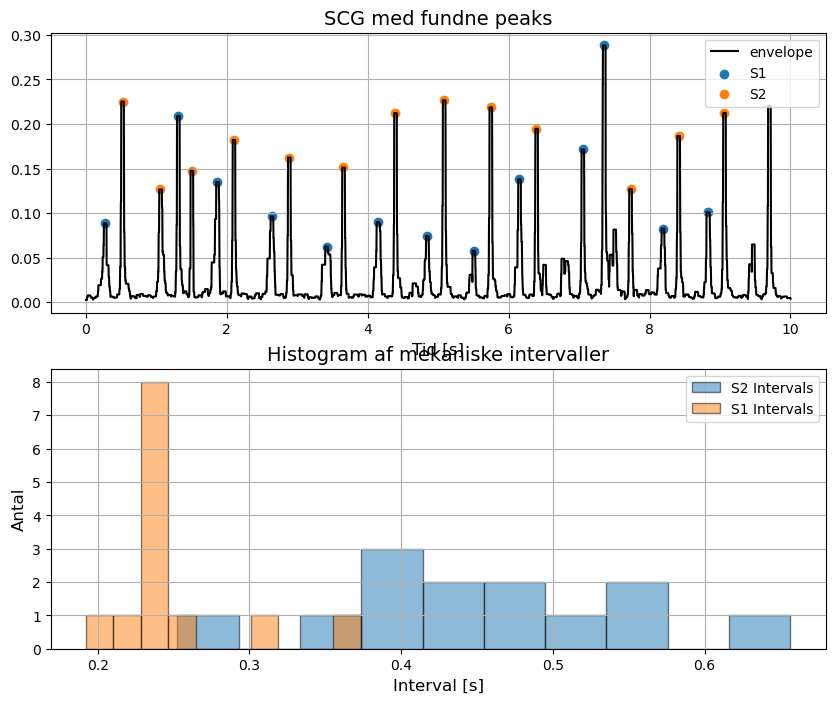

In [37]:
fig, axs = plt.subplots(2,1, figsize=(10,8)); 
axs[0].plot(t_lubdub,e, label="envelope", color='black')
axs[0].scatter([x[1] for x in S1], [x[2 ] for x in S1], label='S1')
axs[0].scatter([x[1] for x in S2], [x[2 ] for x in S2], label='S2')
axs[0].set_xlabel("Tid [s]")
axs[0].set_title('SCG med fundne peaks');
axs[0].legend(loc='upper right')

axs[1].hist([x[0] for x in S2], edgecolor='k', alpha=0.5, label='S2 Intervals')
axs[1].hist([x[0] for x in S1], edgecolor='k', alpha=0.5, label='S1 Intervals')
axs[1].set_title('Histogram af mekaniske intervaller')
axs[1].set_xlabel('Interval [s]')
axs[1].set_ylabel('Antal')
axs[1].legend(loc='upper right')
plt.show()


---

# Workshop: S1/S2-detektion i praksis

Nu sætter I det hele sammen. Fokus: **zero‑phase filtrering**, **peak‑detektion**, **klassifikation** og **validering**.

## Exercise: Finde R-peak og T-peak i et EKG
**Scenarie:**

Du arbejder som ingeniør i et Biotech startup, og har fået til opgave at analysere EKG-signaler fra patienter for at identificere vigtige hjertetræk. 
For at gøre det nemmere at finde de karakteristiske peaks, skal du beregne en envelope af EKG-signalet. 
Din opgave er at bruge envelopen til at finde både R-peaks (hjertets elektriske aktivering) og T-wave peaks (repolarisering).

**Du ved:**
- Hvordan man beregner en envelope for et signal
- Hvordan man bruger peak-detektion på et signal
- Hvad R-peaks og T-waves repræsenterer i et EKG
- Hvordan man laver regler for- og  klassificerer features

**Du skal:**
1. Indlæs et EKG-signal (fx fra `files/ECGPCG.csv` eller et andet relevant datasæt)
2. Beregn envelopen af EKG-signalet
3. Brug peak-detektion på envelopen til at finde R-peaks
4. Identificér også peaket for T-wave
5. Visualisér EKG, envelope, R-peaks og T-wave peaks i samme plot
6. Diskutér hvordan envelopen hjælper med at identificere disse features

**Skriv dit program i:** `files/envelope_ekg_peaks.py`

### Svar

For at identificere R-peaks og T-wave peaks i et EKG-signal, bruges envelopen til at fremhæve de overordnede udsving i signalet. En envelope og gør det lettere at finde de største udsving, som ofte svarer til de fysiologisk vigtige peaks.

**Tankerne bag valgene:**
- Envelopen beregnes som et glidende maksimum af det absolutte (rectificerede) signal. Dette fremhæver store udsving og undertrykker små variationer og støj.
- R-peaks findes som de højeste peaks i envelopen, da de repræsenterer hjertets elektriske aktivering og er de mest markante udsving i EKG.
- For at finde T-wave peaks, søges der efter et lokalt maksimum i envelopen kort tid efter hver R-peak (typisk 80-150 ms efter). Dette skyldes, at T-bølgen fysiologisk følger efter R-takken.
- Parametre som vinduesstørrelse og søgeinterval er valgt ud fra typiske fysiologiske værdier, men kan justeres afhængigt af signalets samplingfrekvens og kvalitet.

Denne metode gør det muligt at automatisere peak-detektion og visualisere både R- og T-bølger tydeligt, hvilket er nyttigt i både analyse og klinisk praksis.

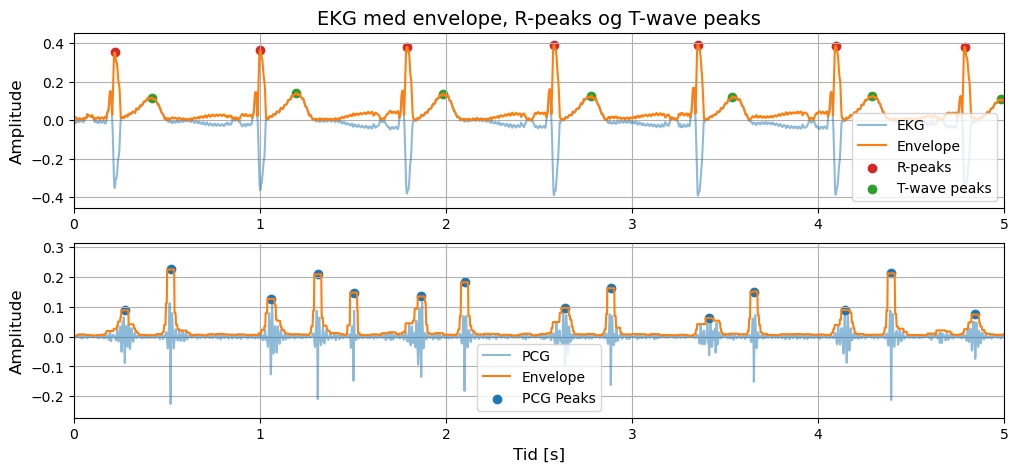

In [44]:
# Svar: Envelop af EKG
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, filtfilt, butter
import pandas as pd
fs = 8000
filename = "files/ECGPCG.csv" 
def envelope(x, window=51):
    mean_x = np.mean(x)
    s0 = x - mean_x
    r = np.abs(s0)
    mov_max = np.zeros_like(r)
    half_w = window // 2
    for i in range(len(r)):
        start = max(i - half_w, 0)
        end = min(i + half_w + 1, len(r))
        mov_max[i] = np.max(r[start:end])
    env = mov_max + mean_x
    return env

# Indlæs data
timestamp, ecg, pcg = np.loadtxt(filename,delimiter=",", skiprows=1, unpack=True)

fc = [1,300]
b, a = butter(4, fc, fs=fs, btype='bandpass') 
ecg = filtfilt(b,a,ecg)
# Beregn envelope af EKG
env_ecg = envelope(ecg, window=25)

# Find R-peaks (højeste peaks i envelopen)
r_peaks, _ = find_peaks(env_ecg, height=np.std(env_ecg), distance=int(0.3*fs))

# Find T-wave peaks (efter hver R-peak, søg i et vindue)
t_peaks = []
t_window = int(0.10*fs)  # typisk 150 ms efter R-peak
for i in range(len(r_peaks)-1):
    start = r_peaks[i] + t_window  # tidligst 100 ms efter R
    end =   r_peaks[i+1]-t_window  # Senest 100 ms før næste R
    if end > start:
        RR_window = env_ecg[start:end]
        # index of max in RR_window
        RR_window_idx = np.argmax(RR_window)
        t_peaks.append(start + RR_window_idx)

fc = [50,300]
b, a = butter(4, fc, fs=fs, btype='bandpass') 
pcg = filtfilt(b,a,pcg)

# find peaks in pcg signal envelop
env_pcg = envelope(pcg,301)
# Peaks i envelopen
pks, _ = find_peaks(env_pcg, distance=int(0.15*fs), height=np.std(env_pcg))

# Plot
fig, axs = plt.subplots(2,1,figsize=(12,5))
axs[0].plot(timestamp, ecg, label="EKG", alpha=0.5)
axs[0].plot(timestamp, env_ecg, label="Envelope", color="C1")
axs[0].scatter(timestamp[r_peaks], env_ecg[r_peaks], color="C3", label="R-peaks")
axs[0].scatter(timestamp[t_peaks], env_ecg[t_peaks], color="C2", label="T-wave peaks")
axs[0].set_title("EKG med envelope, R-peaks og T-wave peaks")
axs[0].set_ylabel("Amplitude")
axs[0].legend()
axs[0].set_xlim(timestamp[0], timestamp[min(len(timestamp)-1, 5*fs)])  # zoom evt. ind på første 5 sekunder

axs[1].plot(timestamp, pcg, label="PCG", alpha=0.5)
axs[1].plot(timestamp, env_pcg, label="Envelope", color="C1")
axs[1].scatter(timestamp[pks], env_pcg[pks], label="PCG Peaks")
axs[1].set_xlabel("Tid [s]")
axs[1].set_ylabel("Amplitude")
axs[1].set_xlim(timestamp[0], timestamp[min(len(timestamp)-1, 5*fs)])  # zoom evt. ind på første 5 sekunder
axs[1].legend()
plt.show()

# Saml alle peaks og deres klassifikationer og amplituder
all_peaks = []
for idx in r_peaks:
    all_peaks.append(('R', idx, env_ecg[idx]))
for idx in t_peaks:
    all_peaks.append(('T', idx, env_ecg[idx]))
for idx in pks:
    all_peaks.append(('PCG_PEAK', idx, env_pcg[idx]))
# Sortér efter tid
all_peaks_sorted = sorted(all_peaks, key=lambda x: x[1])

# Gem til Excel/CSV
df = pd.DataFrame(all_peaks_sorted, columns=['classification', 'index', 'amplitude'])
df.to_csv('files/peaks_ECGPCG.csv', index=False)

## Exercise: Forbedr S₁/S₂‑klassifikation ved brug af EKG

**Scenarie:**

Du arbejder som ingeniør i et Biotech startup og skal forbedre automatisk klassifikation af hjertelyde. 
Du har synkroniserede optagelser af EKG og PCG. 
Målet er at bruge EKG‑R‑peaks som reference til at mærke S₁ og S₂ i PCG.


**Du ved:**

- Hvad R- og T‑peaks og S₁/S₂ repræsenterer fysiologisk
- Hvordan man skriver simple regler til klassifikation
- Hvordan man laver regler klassificerings regler

**Du skal:**

- Indlæs `timestamp`, `ecg`, `pcg` fra `files/ECGPCG.csv` og forbered signalerne (filtrering + envelope).
- Indlæs `classification`, `index`, `amplitude` fra `files/peaks_ECGPCG.csv`. index er signal index for en given peak. Amplitude er 
    - filen bliver genereret i min besvarelse til forrige opgave. 
    - SÅ! i må gerne benytte jeres egne svar.
- Lave 1 eller 2 ektra S1/S2 klassifikations regler 
    - Beskriv jeres regel, samt hvorfor i mener den virker før i laver koden. (Planlægning af kode er absolut vigitgt!) 
    - Implementer jeres regel
    - Vurder om jeres regel giver mening, og opdater reglsættet
- Gem fundne peaks i `files/peaks_ECGPCG2.csv` med kolonnerne `classification,timestamp,amplitude`.
- Visualisér EKG med R‑peaks og PCG med fundne S₁/S₂; valider med et histogram hvad tidsforskellene er fra R→S1 og R→S2

**Skriv dit program i:** `files/classify_s1s2_with_ecg.py`

## Svar
Detect S1 and S2 in PCG using EKG R-peaks as temporal anchors.

Rules implemented (brief):
1) Simple amplitude gating: keep peaks above a fraction of the envelope std to avoid classifying noise as heart sounds.
2) S1 is expected shortly after the R-peak (approx 10-150 ms). 

   Classify the first Peak in this 10-150 ms window after the R peak as S1. *Initially I guessed 25-120, but I missed a few S1 sounds.*
3) S2 is expected later (approx 250-600 ms after R). 

   Classify the first Peak in this 250-600 ms wndow as S2.

<>:171: SyntaxWarning: invalid escape sequence '\D'
<>:171: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_147450/494913346.py:171: SyntaxWarning: invalid escape sequence '\D'
  axs[2].set_xlabel('$\Delta$ Time (s) from R peak', )


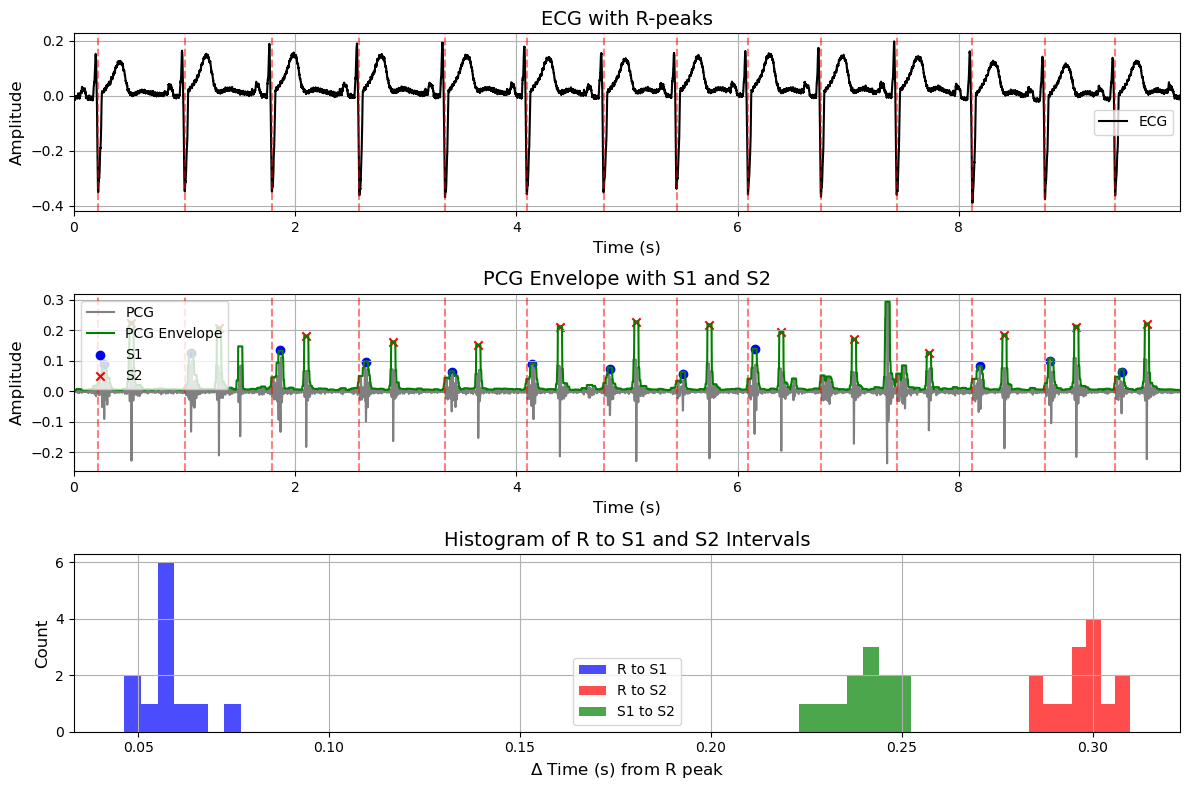

In [42]:
# %load files/classify_s1s2_with_ecg.py
#!/usr/bin/env python3
"""
classify_s1s2_with_ecg.py

Detect S1 and S2 in PCG using EKG R-peaks as temporal anchors.

Rules implemented (brief):
1) Simple amplitude gating: keep peaks above a fraction of the envelope std to
   avoid classifying noise as heart sounds.
2) S1 is expected shortly after the R-peak (approx 10-150 ms). We search for a local
   maximum of the PCG envelope in this window.
3) S2 is expected later (approx 250-600 ms after R). We search for a local maximum
   in that window and require it to be reasonably sized relative to the local envelope.

Produces: files/peaks_ECGPCG2.csv and a PNG with plots in the same folder.
"""
import numpy as np
from scipy.signal import butter, filtfilt, hilbert
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
def envelope(x, window=50):
    """
    Beregn en envelope for et signal x.
    """
    # 1. Fjern gennemsnittet
    mean_x = np.mean(x)
    s0 = x - mean_x

    # 2. Rectify (absolut værdi)
    r = np.abs(s0)

    # 3. Moving Maximum
    mov_max = np.zeros_like(r)
    half_w = window // 2
    for i in range(len(r)):
        start = max(i - half_w, 0)
        end = min(i + half_w + 1, len(r))
        mov_max[i] = np.max(r[start:end])

    # 4. Tilføj gennemsnittet tilbage
    env = mov_max + mean_x
    return env


class CardiacCycle:
    def __init__(self, r_idx, fs):
        self.r_idx = r_idx
        self.s1_idx = np.nan
        self.s1_amp = np.nan
        self.s2_idx = np.nan
        self.s2_amp = np.nan
        self.fs = fs

    def r_to_s1(self):
        return (self.s1_idx - self.r_idx) / self.fs
    def r_to_s2(self):
        return (self.s2_idx - self.r_idx) / self.fs
    def s1_to_s2(self):
        return (self.s2_idx - self.s1_idx) / self.fs
    
    @property
    def R(self):
        return (self.r_idx / self.fs) if (self.r_idx is not np.nan) else np.nan
    
    @property
    def S1(self):
        return (self.s1_idx / self.fs) if (self.s1_idx is not np.nan) else np.nan
    @property
    def S2(self):
        return (self.s2_idx / self.fs) if (self.s2_idx is not np.nan) else np.nan
    
    def __repr__(self):
        return f"CardiacCycle(R={self.R}, S1={self.S1}, S2={self.S2})"
    
    def as_list(self):
        return [self.R, self.S1, self.S2]


def bandpass(x, fs, low, high, order=3):
    b, a = butter(order, [low, high],fs=fs, btype='bandpass')
    return filtfilt(b, a, x)


def main():
    # use relative paths to the signals_2/files folder (run from repo root)
    ecgpcg_path = 'files/ECGPCG.csv'
    peaks_path = 'files/peaks_ECGPCG.csv'
    fig_path = 'files/s1s2_classification.png'
    out_path = 'files/peaks_ECGPCG2.csv'

    # read ECG/PCG using numpy (timestamp, ECG, PCG)
    ts, ecg, pcg = np.loadtxt(ecgpcg_path, delimiter=',', skiprows=1, unpack=True)
    # sampling frequency (robust median diff)
    dt = np.median(np.diff(ts))
    fs = 1.0 / dt

    # bandpass filter PCG, and compute envelope
    pcg = bandpass(pcg, fs=fs, low=50, high=300)
    pcg_env = envelope(pcg, window=301)
    
    # load peaks using numpy: classification (str), timestamp (float), amplitude (float)
    cls_col, index_col, amp_col = np.loadtxt(peaks_path, delimiter=',', dtype=str, skiprows=1, unpack=True)
    index_col = index_col.astype(float)
    amp_col = amp_col.astype(float)
    S = 0
    cardiac_cycles: list[CardiacCycle] = []
    C = None
    s1_win = (0.01, 0.15)   # 25-150 ms after R
    s2_win = (0.25, 0.60)    # 250-450 ms after R
    for i in range(len(cls_col)):   
        if cls_col[i] == "R":
            if C is not None:
                cardiac_cycles.append(C)
            C = CardiacCycle(r_idx=index_col[i], fs=fs)
            continue

        elif cls_col[i] == "PCG_PEAK":
            if C is None:
                continue
            S = index_col[i]

            # Implement Rules for S1 and S2 classification
            if s1_win[0] < (S - C.r_idx) / C.fs < s1_win[1] and np.isnan(C.s1_idx):
                # S1 rule
                C.s1_idx = index_col[i]
                C.s1_amp = amp_col[i]
            elif s2_win[0] < (S - C.r_idx) / C.fs < s2_win[1] and np.isnan(C.s2_idx):
                # S2 rule
                C.s2_idx = index_col[i]
                C.s2_amp = amp_col[i]
    if C is not None:
        cardiac_cycles.append(C)    


    # Visualize results
    s1_times = [c.S1 for c in cardiac_cycles]
    s1_amps = [c.s1_amp for c in cardiac_cycles]
    s2_times = [c.S2 for c in cardiac_cycles]
    s2_amps = [c.s2_amp for c in cardiac_cycles]
    # Plot results
    _,axs = plt.subplots(3,1,figsize=(12, 8))
    axs[0].plot(ts, ecg, label='ECG', color='k')
    axs[1].plot(ts, pcg, label='PCG', color='gray')
    axs[1].plot(ts, pcg_env, label='PCG Envelope', color='g')
    for c in cardiac_cycles:
        axs[0].axvline(c.R, color='r', linestyle='--', alpha=0.5)   
        axs[1].axvline(c.R, color='r', linestyle='--', alpha=0.5)   
    axs[1].scatter(s1_times, s1_amps, label='S1', color='b', marker='o')
    axs[1].scatter(s2_times, s2_amps, label='S2', color='r', marker='x')
    axs[0].set_title('ECG with R-peaks')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_xlim(ts[0], ts[-1])
    axs[0].legend()
    axs[1].set_title('PCG Signal')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_xlim(ts[0], ts[-1])
    axs[1].set_title('PCG Envelope with S1 and S2')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_xlim(ts[0], ts[-1])
    axs[1].legend()


    axs[2].hist([c.r_to_s1() for c in cardiac_cycles if not np.isnan(c.s1_idx)], bins=7, alpha=0.7, label='R to S1', color='b')
    axs[2].hist([c.r_to_s2() for c in cardiac_cycles if not np.isnan(c.s2_idx)], bins=7, alpha=0.7, label='R to S2', color='r')
    axs[2].hist([c.s1_to_s2() for c in cardiac_cycles if not np.isnan(c.s1_idx) and not np.isnan(c.s2_idx)], bins=7, alpha=0.7, label='S1 to S2', color='g')
    axs[2].set_title('Histogram of R to S1 and S2 Intervals')
    axs[2].set_xlabel('$\Delta$ Time (s) from R peak', )
    axs[2].set_ylabel('Count')
    axs[2].legend() 
    plt.tight_layout()
    

    plt.savefig(fig_path)
    
    # save results to CSV using np — replace None with NaN and ensure numeric dtype
    list_with_results = np.array([c.as_list() for c in cardiac_cycles], dtype=float)
    header = 'R,S1,S2'
    fmt = '%.3f'
    np.savetxt(out_path, list_with_results, delimiter=',', header=header, fmt=fmt)

    
    # This code locks, so we save the figure after saving to data of 
    plt.show()


if __name__ == '__main__':
    main()

